In [1]:
import pandas as pd

data = pd.read_pickle("/home/abindal/pan-2024/PAN/GPT.pkl")

print(data.head())
print(len(data))

/tmp/ipykernel_1935/1363368681.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


                                                text source Type
0  sexhow railway station was a railway station l...     ai  GPT
1  in finnish folklore, all places and things, an...     ai  GPT
2  in mathematics, specifically differential calc...     ai  GPT
3  is a japanese shōjo manga series written and i...     ai  GPT
4  robert milner "rob" bradley, jr. (born august ...     ai  GPT
300000


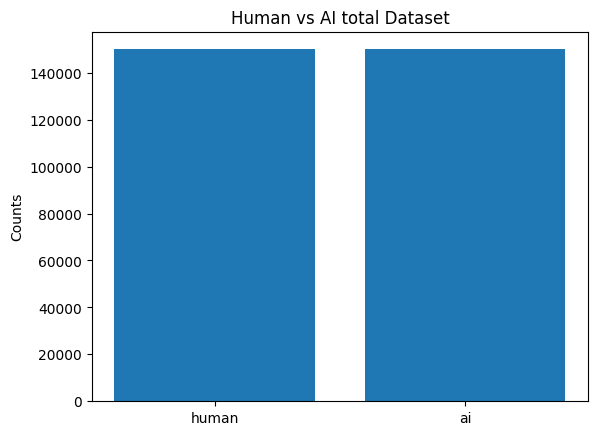

In [3]:
import matplotlib.pyplot as plt

plt.bar(['human','ai'],data['source'].value_counts())
plt.ticklabel_format(style='plain', axis='y')
plt.title('Human vs AI total Dataset')
plt.ylabel('Counts')
plt.show()

In [4]:
def count_words(text):
    return len(text.split())

data['wordCount'] = data['text'].apply(count_words)

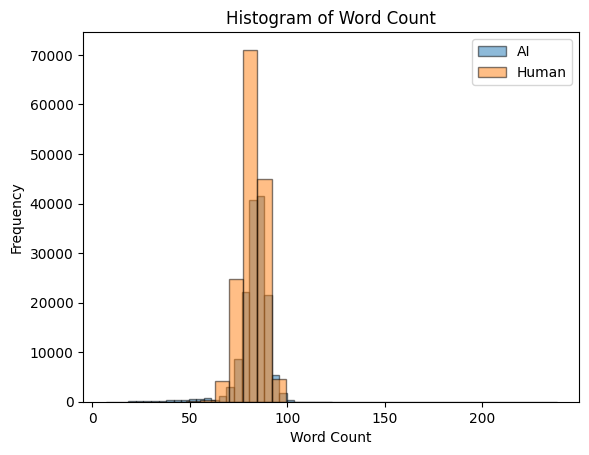

In [5]:
# Filter DataFrame by categories
aiWordCount = data[data['source'] == 'ai']['wordCount']
humanWordCount = data[data['source'] == 'human']['wordCount']

# Plot histograms for each category
plt.hist(aiWordCount, bins=30, edgecolor='black', alpha=0.5, label='AI')
plt.hist(humanWordCount, bins=30, edgecolor='black', alpha=0.5, label='Human')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Histogram of Word Count')
plt.legend()
plt.show()

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

X = data['text']
y = data['source'].map({'human': 0, 'ai': 1})

# Split the data into training and testing sets
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

In [7]:
# Initialize the tf-idf vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_matrix_val = tfidf_vectorizer.transform(X_val)
tfidf_matrix_test = tfidf_vectorizer.transform(X_test)

In [8]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [9]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

clf = xgb.XGBClassifier(objective='binary:logistic', n_estimators=1000, device = device, seed=42)
clf.set_params(learning_rate=0.1, max_depth=7, eval_metric='logloss')

# Fit the classifier to the training set
clf.fit(tfidf_matrix_train, y_train, eval_set=[(tfidf_matrix_val, y_val)], verbose=True)

y_pred = clf.predict(tfidf_matrix_test)
print('Accuracy: {}'.format(accuracy_score(y_test, y_pred)))

[0]	validation_0-logloss:0.69319
[1]	validation_0-logloss:0.69350
[2]	validation_0-logloss:17.54142
[3]	validation_0-logloss:18.12240
[4]	validation_0-logloss:17.68761
[5]	validation_0-logloss:18.13846
[6]	validation_0-logloss:17.71053
[7]	validation_0-logloss:18.15211
[8]	validation_0-logloss:17.70247
[9]	validation_0-logloss:18.18517
[10]	validation_0-logloss:17.73621
[11]	validation_0-logloss:18.23052
[12]	validation_0-logloss:17.82948
[13]	validation_0-logloss:17.77470
[14]	validation_0-logloss:18.23948
[15]	validation_0-logloss:17.79019
[16]	validation_0-logloss:18.28707
[17]	validation_0-logloss:17.88635
[18]	validation_0-logloss:18.39142
[19]	validation_0-logloss:17.90598
[20]	validation_0-logloss:18.39895
[21]	validation_0-logloss:18.04558
[22]	validation_0-logloss:17.99744
[23]	validation_0-logloss:18.51186
[24]	validation_0-logloss:18.05818
[25]	validation_0-logloss:18.52009
[26]	validation_0-logloss:18.13369
[27]	validation_0-logloss:18.53121
[28]	validation_0-logloss:18.531

/home/abindal/pan-2024/.venv/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [17:58:47] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


In [10]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
#import torch

# Load pre-trained model and tokenizer
model = GPT2LMHeadModel.from_pretrained('gpt2').to(device)
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

/home/abindal/pan-2024/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
from tqdm import tqdm

def calculate_ppl(text):
    input_ids = tokenizer.encode(text, return_tensors='pt')
    with torch.no_grad():
        loss = model(input_ids.to(device), labels=input_ids)[0]
    return torch.exp(loss).item()

# Calculate perplexity for each text
tqdm.pandas(desc = "Processing perplexity...")
df_shuffled = data.sample(frac=1, random_state=42).reset_index(drop=True).head(len(data)//2)
df_shuffled['ppl'] = df_shuffled['text'].progress_apply(calculate_ppl)

Processing perplexity...:   0%|          | 0/150000 [00:00<?, ?it/s]

Processing perplexity...: 100%|██████████| 150000/150000 [34:02<00:00, 73.44it/s]


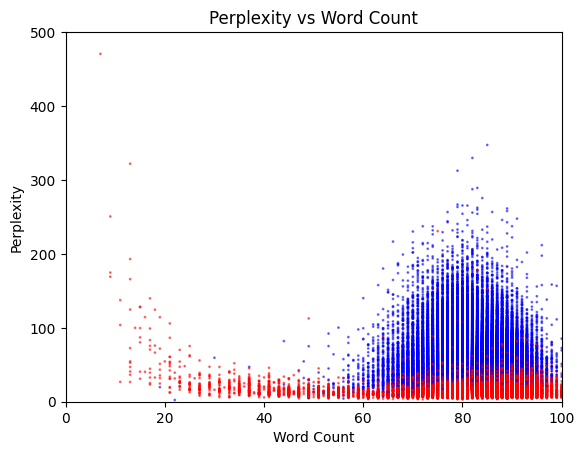

In [17]:
#scatter plot of perplexity and word count with different color for each category
plt.scatter(df_shuffled['wordCount'], df_shuffled['ppl'], c=df_shuffled['source'].map({'human': 'blue', 'ai': 'red'}),s=1, alpha = 0.5)
plt.xlabel('Word Count')
plt.ylabel('Perplexity')
plt.title('Perplexity vs Word Count')
plt.ylim(0, 500)
plt.xlim(0, 100)
plt.show()

In [18]:
print(df_shuffled.head(10))

                                                text source Type  wordCount  \
0  sekhukhune i (matsebe; circa 1814 – 13 septemb...     ai  GPT         89   
1  mount washington is a  peak in the white mount...     ai  GPT         88   
2  acer hillsi is an extinct maple species that w...     ai  GPT         81   
3  derrick george sherwin (16 april 1936 – 17 oct...  human  GPT         82   
4  the windows shell is the graphical user interf...  human  GPT         78   
5  the hetoimasia, etimasia (greek ἑτοιμασία, "pr...     ai  GPT         51   
6  the defining moment: fdr's hundred days and th...  human  GPT         83   
7  sister elizabeth kenny (20 september 1880 – 31...     ai  GPT         88   
8  deng longguang  was a kmt general during the c...     ai  GPT         88   
9  trace amounts: autism, mercury, and the hidden...  human  GPT         80   

         ppl  
0  30.667200  
1  45.146324  
2  18.370382  
3  67.520676  
4  58.743088  
5  19.093073  
6  67.164688  
7  26.7016

In [26]:
# convert wordCount and ppl to tensor
wordCount = torch.tensor(df_shuffled['wordCount'].values)
ppl = torch.tensor(df_shuffled['ppl'].values)

# merge wordCount and ppl into a single tensor
X_ppl = torch.stack((wordCount, ppl), dim=1)
print(X_ppl.shape)

# convert source to tensor
y_ppl = torch.tensor(df_shuffled['source'].map({'human': 0, 'ai': 1}).values)
print(y_ppl.shape)

torch.Size([150000, 2])
torch.Size([150000])


In [27]:
# Split the data into training, validation and testing sets
X_train_ppl, X_val_test_ppl, y_train_ppl, y_val_test_ppl = train_test_split(X_ppl, y_ppl, test_size=0.3, random_state=42)
X_val_ppl, X_test_ppl, y_val_ppl, y_test_ppl = train_test_split(X_val_test_ppl, y_val_test_ppl, test_size=0.5, random_state=42)

# Initialize the classifier
clf_ppl = xgb.XGBClassifier(objective='binary:logistic', n_estimators=1000, device = device, seed=42)
clf_ppl.set_params(learning_rate=0.1, max_depth=7, eval_metric='logloss')

# Fit the classifier to the training set
clf_ppl.fit(X_train_ppl.cpu(), y_train_ppl.cpu(), eval_set=[(X_val_ppl, y_val_ppl)], verbose=True)

y_pred_ppl = clf_ppl.predict(X_test_ppl)
print('Accuracy: {}'.format(accuracy_score(y_test_ppl, y_pred_ppl)))

[0]	validation_0-logloss:0.63480
[1]	validation_0-logloss:0.58705
[2]	validation_0-logloss:0.54743
[3]	validation_0-logloss:0.51420
[4]	validation_0-logloss:0.48608
[5]	validation_0-logloss:0.46212
[6]	validation_0-logloss:0.44165
[7]	validation_0-logloss:0.42405
[8]	validation_0-logloss:0.40888
[9]	validation_0-logloss:0.39573
[10]	validation_0-logloss:0.38435
[11]	validation_0-logloss:0.37450
[12]	validation_0-logloss:0.36594
[13]	validation_0-logloss:0.35846
[14]	validation_0-logloss:0.35195
[15]	validation_0-logloss:0.34628
[16]	validation_0-logloss:0.34134
[17]	validation_0-logloss:0.33701
[18]	validation_0-logloss:0.33327
[19]	validation_0-logloss:0.32998
[20]	validation_0-logloss:0.32713
[21]	validation_0-logloss:0.32462
[22]	validation_0-logloss:0.32245
[23]	validation_0-logloss:0.32054
[24]	validation_0-logloss:0.31890
[25]	validation_0-logloss:0.31744
[26]	validation_0-logloss:0.31620
[27]	validation_0-logloss:0.31513
[28]	validation_0-logloss:0.31420
[29]	validation_0-loglos